In [1]:
import numpy
import os
import cPickle as pickle
import os.path
import matplotlib.pyplot as plt
import time
import json
import MeCab
import re
import codecs

import sys
sys.path.append("../../MyPythonModule")
import mymodule
from LDA_kai import LDA

In [2]:
def status_writer(dst_dir,opt,comment=None):
    status_file_path = os.path.join(dst_dir,"status.txt")
    with open(status_file_path,"w") as fo:
        for k,v in opt.items():
            print >> fo,k,"=",v
        print >> fo,""
        if comment != None:
            print >> fo,"comment"
            print >> fo,comment

In [3]:
def suffix_generator(target=None,is_largest=False):
    suffix = ""
    if target != None:
        suffix += "_" + target
    if is_largest == True:
        suffix += "_largest"
    return suffix

In [4]:
def perp_graph(perp_path,opt="perp"):
    dir = os.path.dirname(perp_path)
    f = open(perp_path)
    perplist = []
    for line in f:
        elm = line.split(",")
        elm[1].rstrip()#改行記号除去
        elm = float(elm[1])
        perplist.append(elm)
    plt.plot(perplist)
    plt.savefig(os.path.join(dir,opt+".png"))
    plt.clf()#現在描画したグラフを消す(消さないと次回の描画時に残る)

In [5]:
def output_summary(exp_dir,lda):
    with open(os.path.join(exp_dir,"summary.txt"),"w") as fout:
        phi = lda.phi()
        for k in xrange(lda.K):
            print "\nTopic %d" % (k)
            print >> fout, "\nTopic %d" % (k+1)
            for w in numpy.argsort(-phi[k])[:20]:
                try:
                    print >> fout, "%s\t%f" % (lda.vocas[w], phi[k,w])
                    print "%s: %f" % (lda.vocas[w], phi[k,w])
                except:
                    print "cdecs_error"

In [6]:
search_word = u"iPhone"
max_page = 10
root_dir = "../Data/Search_" + search_word + "_" + unicode(max_page) + "_add_childs" 
is_largest = True
target = "myexttext"
G_name = "G" + suffix_generator(target=target,is_largest=is_largest)
use_to_link = "to_ext_links"
K = 10
iteration = 50
alpha = 0.001
beta = 0.001
no_below = 5#単語の最低出現文書数
no_above = 0.2#単語の最大出現文書比率
no_less = 20#文書に含まれる最低単語数
do_hparam_update = False#パラメータを更新するか否か
chasen_dir_name = "Chasen" + suffix_generator(target,is_largest)
exp_name = "K" + unicode(K) + suffix_generator(target,is_largest)
comment = None

In [7]:
chasen_dir = os.path.join(root_dir,chasen_dir_name)
if exp_name == None:
    exp_name = "K" + unicode(K) + "_freqcut3" #+"_"+unicode(try_no)
exp_dir = os.path.join(root_dir,exp_name)
if not os.path.exists(exp_dir):
    os.mkdir(exp_dir)

In [8]:
files = os.listdir(chasen_dir)
files = [file for file in files if os.path.splitext(file)[1] == ".txt"]
mymodule.sort_nicely(files)
files

[u'0.txt',
 u'2.txt',
 u'3.txt',
 u'4.txt',
 u'5.txt',
 u'6.txt',
 u'7.txt',
 u'9.txt',
 u'10.txt',
 u'11.txt',
 u'12.txt',
 u'13.txt',
 u'14.txt',
 u'15.txt',
 u'16.txt',
 u'17.txt',
 u'18.txt',
 u'19.txt',
 u'20.txt',
 u'21.txt',
 u'22.txt',
 u'23.txt',
 u'24.txt',
 u'25.txt',
 u'26.txt',
 u'27.txt',
 u'28.txt',
 u'29.txt',
 u'30.txt',
 u'31.txt',
 u'32.txt',
 u'33.txt',
 u'34.txt',
 u'35.txt',
 u'36.txt',
 u'37.txt',
 u'38.txt',
 u'39.txt',
 u'40.txt',
 u'41.txt',
 u'42.txt',
 u'43.txt',
 u'44.txt',
 u'45.txt',
 u'46.txt',
 u'47.txt',
 u'48.txt',
 u'49.txt',
 u'50.txt',
 u'51.txt',
 u'52.txt',
 u'53.txt',
 u'56.txt']

In [9]:
len(files)

53

In [10]:
with open(os.path.join(root_dir,"file_id_dict.dict"),"r") as fi:
    file_id_dict = pickle.load(fi)

In [11]:
corpus = []
for i,file in enumerate(files):
    with open(os.path.join(chasen_dir,file),"r") as fi:
        doc = [word.rstrip() for word in fi.readlines()]
        corpus.append(doc)
len(corpus)

53

In [12]:
corpus

[['\xe3\x83\xad\xe3\x82\xb0\xe3\x82\xa4\xe3\x83\xb3',
  '\xe3\x83\x9d\xe3\x82\xa4\xe3\x83\xb3\xe3\x83\x88',
  '\xe6\x9c\x9f\xe9\x99\x90',
  'iPhone',
  'iPhone',
  'PlusiPhone',
  'iPhone',
  'Plus',
  'with',
  'AppleCare',
  'Services',
  '\xe3\x83\xa1\xe3\x83\x83\xe3\x82\xbb\xe3\x83\xbc\xe3\x82\xb8',
  '\xe3\x83\x97\xe3\x83\xa9\xe3\x82\xb9',
  '\xe3\x83\xa1\xe3\x83\x83\xe3\x82\xbb\xe3\x83\xbc\xe3\x82\xb8',
  '\xe5\x88\x9d\xe6\x9c\x9f',
  '\xe3\x83\x86\xe3\x82\xb6\xe3\x83\xaa\xe3\x83\xb3\xe3\x82\xb0',
  'iPhone',
  '\xe3\x83\xa2\xe3\x83\x90\xe3\x82\xa4\xe3\x83\xab\xe3\x83\xab\xe3\x83\xbc\xe3\x82\xbf\xe3\x83\xbc',
  '\xe4\xbb\xa3\xe3\x82\x8f\xe3\x82\x8a',
  'LTE',
  'NET',
  'for',
  'DATA',
  'iPhone',
  'au',
  'iPhone',
  '\xe3\x82\xa2\xe3\x82\xaf\xe3\x82\xbb\xe3\x82\xb5\xe3\x83\xaa\xe3\x83\xbc',
  'iPad',
  '\xe3\x82\xb3\xe3\x83\xb3\xe3\x83\x94\xe3\x83\xa5\xe3\x83\xbc\xe3\x82\xbf',
  '\xe3\x82\xb3\xe3\x83\xb3\xe3\x83\x94\xe3\x83\xa5\xe3\x83\xbc\xe3\x82\xbf',
  'Apple',
  'Pay',
  

In [13]:
smartinit = True
lda = LDA(K, alpha, beta)
lda.set_corpus(corpus,no_below=no_below,no_above=no_above,no_less=no_less,smartinit=smartinit,file_id_dict=file_id_dict)

made words 2018-12-04 12:39:18.331687
made corpus 2018-12-04 12:39:18.720467


In [14]:
M = len(lda.docs)
M

43

In [15]:
V = len(lda.vocas)
V

157

In [16]:
lda.vocas

['\xe3\x83\xad\xe3\x82\xb0\xe3\x82\xa4\xe3\x83\xb3',
 '\xe3\x83\x9d\xe3\x82\xa4\xe3\x83\xb3\xe3\x83\x88',
 'iPhone',
 'Plus',
 'with',
 'AppleCare',
 '\xe3\x83\xa1\xe3\x83\x83\xe3\x82\xbb\xe3\x83\xbc\xe3\x82\xb8',
 'au',
 'iPad',
 '\xe3\x82\xb3\xe3\x83\xb3\xe3\x83\x94\xe3\x83\xa5\xe3\x83\xbc\xe3\x82\xbf',
 'Apple',
 'Pay',
 '\xe3\x82\xab\xe3\x83\xbc\xe3\x83\x89',
 '\xe6\x83\x85\xe5\xa0\xb1',
 '\xe6\xb3\x95\xe4\xba\xba',
 '\xe3\x81\x8a\xe5\xae\xa2',
 '\xe5\x86\x85\xe5\xae\xb9',
 'ID',
 '\xe3\x83\x9c\xe3\x82\xbf\xe3\x83\xb3',
 '\xe7\x94\xbb\xe9\x9d\xa2',
 '\xe6\xa9\x9f\xe7\xa8\xae',
 '\xe3\x82\xaf\xe3\x83\xac\xe3\x82\xb8\xe3\x83\x83\xe3\x83\x88\xe3\x82\xab\xe3\x83\xbc\xe3\x83\x89',
 '\xe3\x82\xb9\xe3\x83\x9e\xe3\x83\xbc\xe3\x83\x88',
 '\xe3\x83\x95\xe3\x82\xa9\xe3\x83\xb3',
 '\xe3\x82\xa4\xe3\x83\xb3\xe3\x82\xbf\xe3\x83\xbc\xe3\x83\x8d\xe3\x83\x83\xe3\x83\x88',
 'XR',
 '\xe6\x97\xa5\xe6\x9c\xac',
 '\xe3\x83\x87\xe3\x82\xa3\xe3\x82\xb9\xe3\x83\x97\xe3\x83\xac\xe3\x82\xa4',
 '\xe6\xa5\xad\

In [17]:
[word.decode("utf-8") for word in lda.vocas]

[u'\u30ed\u30b0\u30a4\u30f3',
 u'\u30dd\u30a4\u30f3\u30c8',
 u'iPhone',
 u'Plus',
 u'with',
 u'AppleCare',
 u'\u30e1\u30c3\u30bb\u30fc\u30b8',
 u'au',
 u'iPad',
 u'\u30b3\u30f3\u30d4\u30e5\u30fc\u30bf',
 u'Apple',
 u'Pay',
 u'\u30ab\u30fc\u30c9',
 u'\u60c5\u5831',
 u'\u6cd5\u4eba',
 u'\u304a\u5ba2',
 u'\u5185\u5bb9',
 u'ID',
 u'\u30dc\u30bf\u30f3',
 u'\u753b\u9762',
 u'\u6a5f\u7a2e',
 u'\u30af\u30ec\u30b8\u30c3\u30c8\u30ab\u30fc\u30c9',
 u'\u30b9\u30de\u30fc\u30c8',
 u'\u30d5\u30a9\u30f3',
 u'\u30a4\u30f3\u30bf\u30fc\u30cd\u30c3\u30c8',
 u'XR',
 u'\u65e5\u672c',
 u'\u30c7\u30a3\u30b9\u30d7\u30ec\u30a4',
 u'\u696d\u754c',
 u'Face',
 u'\u6df1\u5ea6',
 u'\u30ab\u30e1\u30e9',
 u'\u30b7\u30b9\u30c6\u30e0',
 u'\u30b9\u30af\u30ea\u30fc\u30f3',
 u'\u4e16\u754c',
 u'\u8272',
 u'\u6027\u80fd',
 u'\u76ee',
 u'\u30ec\u30d9\u30eb',
 u'\u30ef\u30a4\u30e4\u30ec\u30b9',
 u'\u9854',
 u'\u30d1\u30b9\u30ef\u30fc\u30c9',
 u'\u30bb\u30ad\u30e5\u30ea\u30c6\u30a3',
 u'\u30a2\u30d7\u30ea\u30b1\u30fc\u30b7\u30

In [18]:
doclen_ave = sum([len(_doc) for _doc in lda.docs]) / float(len(lda.docs))
doclen_ave

136.90697674418604

In [19]:
fp = open(os.path.join(exp_dir,"_perp.txt"),"w")
ft = open(os.path.join(exp_dir,"_time.txt"), 'w')
start_time = time.time()

In [20]:
for i in range(iteration):
    #sys.stderr.write("-- %d : %.4f\n" % (i, natm.perplexity()))
    lda.inference()
    perp = lda.perplexity()
    print >> fp,("%d,%f" % (i, perp))
    if i != 0 and i%5 == 0:
        lda.hparam_update(do_alpha=do_hparam_update,do_beta=do_hparam_update)
    if i%100 == 0:
        with open(os.path.join(exp_dir,"instance.pkl"), 'w') as fs:
            pickle.dump(lda,fs)
    sys.stderr.write("-- %d" % (i))
elapsed_time = time.time() - start_time
fp.close()

-- 0-- 1-- 2-- 3-- 4-- 5-- 6-- 7-- 8-- 9-- 10-- 11-- 12-- 13-- 14-- 15-- 16-- 17-- 18-- 19-- 20-- 21-- 22-- 23-- 24-- 25-- 26-- 27-- 28-- 29-- 30-- 31-- 32-- 33-- 34-- 35-- 36-- 37-- 38-- 39-- 40-- 41-- 42-- 43-- 44-- 45-- 46-- 47-- 48-- 49

In [21]:
with open(os.path.join(exp_dir,"instance.pkl"), 'w') as fs:
    pickle.dump(lda,fs)

In [22]:
print >> ft,"alpha=", lda.alpha
print >> ft,"beta=" ,lda.beta
print >> ft,"time=" ,elapsed_time
ft.close()

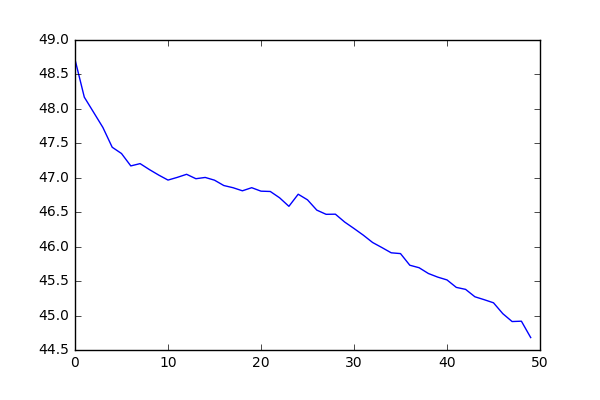

In [23]:
perp_graph(os.path.join(exp_dir,"_perp.txt"),"perp")
from IPython.display import Image, display_png
display_png(Image(os.path.join(exp_dir,"perp.png")))

In [24]:
output_summary(exp_dir,lda)


Topic 0
iPhone: 0.292686
XS: 0.079081
画面: 0.053630
XR: 0.047267
商品: 0.029997
モデル: 0.026361
最大: 0.024543
最新: 0.023634
バッテリー: 0.022725
ユーザー: 0.020907
ホーム: 0.020907
ボタン: 0.019998
アプリ: 0.019089
ワイヤレス: 0.015453
モバイル: 0.013635
ID: 0.013635
TIME: 0.012726
容量: 0.012726
Plus: 0.012726
フォン: 0.009999

Topic 1
機種: 0.150530
au: 0.109478
ポイント: 0.102636
製品: 0.082110
使い方: 0.082110
KDDI: 0.075268
スマ: 0.075268
ホ: 0.061584
文字: 0.047901
内容: 0.047901
料金: 0.041059
深度: 0.034217
メンバー: 0.034217
モード: 0.020533
ページ: 0.020533
ハードウェア: 0.013691
東京: 0.000007
容量: 0.000007
com: 0.000007
データ: 0.000007

Topic 2
情報: 0.231878
個人: 0.120298
お客: 0.074969
KDDI: 0.061021
au: 0.059278
月: 0.031383
Cookie: 0.027896
サイト: 0.026152
コンテンツ: 0.021794
目的: 0.020922
内容: 0.020050
アプリケーション: 0.019179
最新: 0.017435
商品: 0.017435
データ: 0.014820
株式会社: 0.014820
法人: 0.014820
会社: 0.013077
写真: 0.012205
システム: 0.011333

Topic 3
お客様: 0.313575
サイト: 0.158897
プライバシー: 0.064685
規約: 0.060466
データ: 0.054842
アカウント: 0.049217
責任: 0.043592
ソフトウェア: 0.032343
条件: 0.029

In [25]:
status_writer(os.path.join(root_dir,exp_name),{"topic_num":K,"M":M,"V":V,"doclen_ave":doclen_ave,"iteration":iteration,"alpha":alpha,"beta":beta,"no_below":no_below,"no_above":no_above,"no_less":no_less,"is_largest":is_largest,"do_hparam_update":do_hparam_update},comment=comment)